Normal TensorFlow model saved at 'mobilenet_v2_normal.h5'.
Saved artifact at '/tmp/tmp7tnh1jlr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_624')
Output Type:
  TensorSpec(shape=(None, 1000), dtype=tf.float32, name=None)
Captures:
  139345142770640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345142774864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345142775248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345142773712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345142772752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345142775440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345142770832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345142771216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345142773520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139345142760272: T

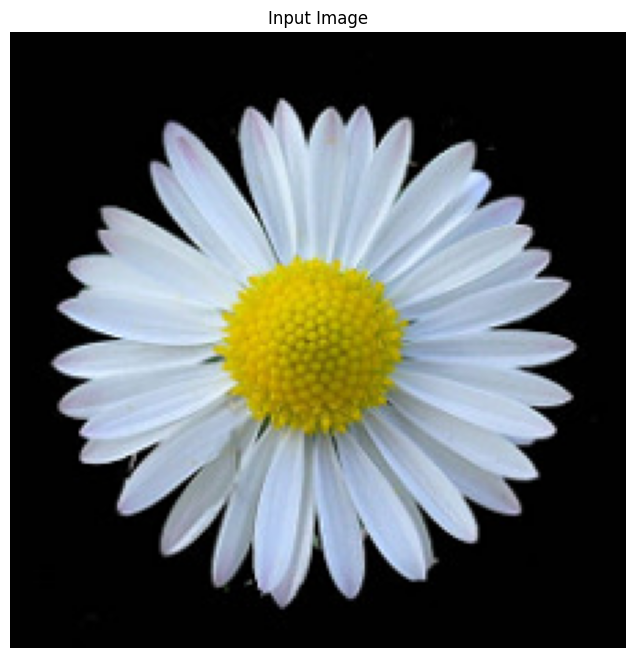


Results Summary:
Top Prediction (Normal Model): daisy (94.16%)
Top Prediction (Optimized Model): daisy (93.89%)


In [5]:
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import time
import matplotlib.pyplot as plt

# Step 1: Load the pre-trained MobileNetV2 model
model = tf.keras.applications.MobileNetV2(weights="imagenet", input_shape=(224, 224, 3))
model.trainable = False

# Save the normal TensorFlow model
normal_model_path = "mobilenet_v2_normal.h5"
model.save(normal_model_path)
print(f"Normal TensorFlow model saved at '{normal_model_path}'.")

# Step 2: Convert the model to TensorFlow Lite format with optimization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the optimized TensorFlow Lite model
tflite_model_path = "mobilenet_v2_optimized.tflite"
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)
print(f"Optimized TensorFlow Lite model saved at '{tflite_model_path}'.")

# Step 3: Load the TensorFlow Lite model for inference
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

# Get input and output details for TensorFlow Lite model
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Step 4: Download and extract the sample image dataset
!wget -q https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!tar -xf flower_photos.tgz

# Select a sample image from the extracted folder
image_path = os.path.join("flower_photos", "daisy", "21652746_cc379e0eea_m.jpg")

# Step 5: Preprocess the input image
def preprocess_image(image_path, target_size):
    img = Image.open(image_path).resize(target_size)
    img_array = np.array(img).astype(np.float32)
    img_preprocessed = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    return np.expand_dims(img_preprocessed, axis=0), img  # Add batch dimension and return original image

input_image, original_image = preprocess_image(image_path, target_size=(224, 224))

# Step 6: Perform inference using the normal TensorFlow model
start_time = time.time()
predictions_normal = model.predict(input_image)
normal_inference_time = time.time() - start_time

decoded_predictions_normal = tf.keras.applications.mobilenet_v2.decode_predictions(predictions_normal, top=3)
print("\nNormal Model Predictions:")
for i, (imagenet_id, label, score) in enumerate(decoded_predictions_normal[0]):
    print(f"{i + 1}: {label} ({score * 100:.2f}%)")

# Step 7: Perform inference using the optimized TensorFlow Lite model
start_time = time.time()
interpreter.set_tensor(input_details[0]["index"], input_image)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]["index"])
tflite_inference_time = time.time() - start_time

decoded_predictions_tflite = tf.keras.applications.mobilenet_v2.decode_predictions(output_data, top=3)
print("\nOptimized TensorFlow Lite Model Predictions:")
for i, (imagenet_id, label, score) in enumerate(decoded_predictions_tflite[0]):
    print(f"{i + 1}: {label} ({score * 100:.2f}%)")

# Step 8: Compare model sizes and size reduction
normal_model_size = os.path.getsize(normal_model_path) / 1024  # in KB
tflite_model_size = os.path.getsize(tflite_model_path) / 1024  # in KB
size_reduction = ((normal_model_size - tflite_model_size) / normal_model_size) * 100

print("\nModel Size Comparison:")
print(f"Normal Model Size: {normal_model_size:.2f} KB")
print(f"Optimized TFLite Model Size: {tflite_model_size:.2f} KB")
print(f"Size Reduction: {size_reduction:.2f}%")

# Step 9: Compare inference times
print("\nInference Time Comparison:")
print(f"Normal Model Inference Time: {normal_inference_time:.4f} seconds")
print(f"Optimized TFLite Model Inference Time: {tflite_inference_time:.4f} seconds")

# Step 10: Display the input image and results
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.axis("off")
plt.title("Input Image")
plt.show()

# Display predictions for both models
print("\nResults Summary:")
print(f"Top Prediction (Normal Model): {decoded_predictions_normal[0][0][1]} ({decoded_predictions_normal[0][0][2] * 100:.2f}%)")
print(f"Top Prediction (Optimized Model): {decoded_predictions_tflite[0][0][1]} ({decoded_predictions_tflite[0][0][2] * 100:.2f}%)")
